## ROMY Array - Map

### Importing

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import obspy
import pandas as pd

from obspy.clients.fdsn import Client, RoutingClient
from obspy.signal.array_analysis import array_transff_wavenumber
from obspy.imaging.cm import obspy_sequential


In [2]:
from functions.read_DEM import __read_DEM
from functions.array_latlon_to_xyz import __array_latlon_to_xyz

In [3]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
    bay_path = '/home/andbro/ontap-ffb-bay200/'
    lamont_path = '/home/andbro/lamont/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/import/ontap-ffb-bay200/'
    lamont_path = '/lamont/'
elif os.uname().nodename in ['lin-ffb-01', 'ambrym', 'hochfelln']:
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/import/ontap-ffb-bay200/'
    lamont_path = '/lamont/'

### Setting Variables

In [4]:
config = {}

config['klim'] = 50.
config['kstep'] = config['klim'] / 100.

config['tbeg'] = obspy.UTCDateTime("2024-03-13 12:00")
config['tend'] = obspy.UTCDateTime("2024-03-13 18:00")

# specify stations of array
config['seeds'] = [
                   'BW.GELB..HH*',
                   'BW.GRMB..HH*',
                   'BW.ALFT..HH*',
                   'BW.BIB..HH*',
                   'BW.TON..HH*',
                   'BW.FFB1..HH*',
                   'BW.FFB2..HH*',
                   'BW.FFB3..HH*',
                   'BW.DROMY..HH*',
                   'GR.FUR..HH*',
]

# specify frequency range
config['fmin'] = 0.001
config['fmax'] = 0.2

# specify reference station
config['ref_station'] = 'BW.DROMY..HH*'

# specify client
config['client'] = RoutingClient("eida-routing")

# path to out figures
config['path_to_figs'] = data_path+"romy_array/figures/"

### Load DEM Model

In [5]:
dem = __read_DEM("ROMY_30m_DEM.tif")

### Defining Methods

In [6]:
def __get_array_stations(seeds, tbeg, tend):

    route =  RoutingClient("eida-routing")

    for _i, seed in enumerate(seeds):

        net, sta, loc, cha = seed.split(".")


        inv = route.get_stations(
                                 network=net,
                                 station=sta,
                                 channel=cha,
                                 starttime=tbeg,
                                 endtime=tend,
                                # latitude=ref_coords[0],
                                # longitude=ref_coords[1],
                                # minradius=0,
                                # maxradius=max_radius,
                            )
        if _i == 0:
            invs = inv
        else:
            invs += inv

    # inv_check.plot(projection="local");

    codes, lon, lat, elev = [], [], [], []
    for h, network in enumerate(invs):
        for i, station in enumerate(network):

            codes.append(f'{invs[h].code}.{station.code}')
            lon.append(station.longitude)
            lat.append(station.latitude)
            elev.append(station.elevation/1000.)

    # create dataframe
    frame = pd.DataFrame({'codes': codes, 'lon': lon, 'lat': lat, 'elev': elev})

    # sort the dataframe
    frame.sort_values(by="codes", inplace=True)

    return frame

In [7]:
array_stations = __get_array_stations(config['seeds'], config['tbeg'], config['tend'])

In [8]:
array_stations = array_stations[array_stations.codes != "GR.FUR"]
fur = pd.DataFrame([{'codes':'GR.FUR', 'lon': 11.27523, 'lat': 48.16295, 'elev': 0.564}])
array_stations = pd.concat([array_stations, fur], ignore_index=True)


In [9]:
array_stations

,codes,lon,lat,elev
0,BW.ALFT,11.279500,48.142334,0.593
1,BW.BIB,11.247300,48.152200,0.599
2,BW.DROMY,11.275476,48.162941,0.571
3,BW.FFB1,11.275065,48.162904,0.572
4,BW.FFB2,11.273684,48.164357,0.577
5,BW.FFB3,11.276289,48.164883,0.562
6,BW.GELB,11.251400,48.162900,0.628
7,BW.GRMB,11.263500,48.140600,0.656
8,BW.TON,11.288809,48.173897,0.564
9,GR.FUR,11.275230,48.162950,0.564


### Add xyz and UTM

In [126]:
array_stations = __array_latlon_to_xyz(array_stations, ref_station="BW.FFB1..BHZ")

/home/brotzer/notebooks/RomyArray/functions/array_latlon_to_xyz.py:37: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'U' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  array_stations.loc[i, "utm_letter"] = str(utm_letter)


In [127]:
array_stations[array_stations.codes == "GR.FUR"]["lat"].iloc[0]

48.16295

## Compute station distance

In [128]:
from functions.calculate_distance_of_stations import __calculate_distance_of_stations

In [129]:
distances = __calculate_distance_of_stations(array_stations, output="km", ref_station=config['ref_station'])
distances

{'BW.ALFT': 2.31,
 'BW.BIB': 2.41,
 'BW.DROMY': 0.0,
 'BW.FFB1': 0.03,
 'BW.FFB2': 0.21,
 'BW.FFB3': 0.22,
 'BW.GELB': 1.79,
 'BW.GRMB': 2.64,
 'BW.TON': 1.57,
 'GR.FUR': 0.02}

In [130]:
cross_distances = __calculate_distance_of_stations(array_stations, output="km", ref_station=None)
cross_distances

array([[0.  , 2.64, 2.31, 2.31, 2.49, 2.52, 3.1 , 1.21, 3.58, 2.31],
       [2.64, 0.  , 2.41, 2.38, 2.38, 2.58, 1.23, 1.77, 3.92, 2.4 ],
       [2.31, 2.41, 0.  , 0.03, 0.21, 0.22, 1.79, 2.64, 1.57, 0.02],
       [2.31, 2.38, 0.03, 0.  , 0.19, 0.24, 1.76, 2.63, 1.59, 0.01],
       [2.49, 2.38, 0.21, 0.19, 0.  , 0.2 , 1.67, 2.75, 1.55, 0.19],
       [2.52, 2.58, 0.22, 0.24, 0.2 , 0.  , 1.86, 2.86, 1.37, 0.23],
       [3.1 , 1.23, 1.79, 1.76, 1.67, 1.86, 0.  , 2.64, 3.04, 1.77],
       [1.21, 1.77, 2.64, 2.63, 2.75, 2.86, 2.64, 0.  , 4.15, 2.63],
       [3.58, 3.92, 1.57, 1.59, 1.55, 1.37, 3.04, 4.15, 0.  , 1.58],
       [2.31, 2.4 , 0.02, 0.01, 0.19, 0.23, 1.77, 2.63, 1.58, 0.  ]])

### Calulcate Distances, Plot Array Geometry and Response

In [212]:
def __plot_array_geometry_and_response0(array, transff, klim, kstep, names=None, unit=None):

    import numpy as np

    # calulcate geometrical center of array
    array_center = [np.median(array[:, 0]), np.median(array[:, 1])]

    # find geometrical limits of array
    lon_min, lon_max = np.min(array[:, 0]), np.max(array[:, 0])
    lat_min, lat_max = np.min(array[:, 1]), np.max(array[:, 1])

    # define bounds
    kxmin, kxmax, kymin, kymax = -klim, klim, -klim, klim


    # _________________________________________________________
    #
    fig, axes = plt.subplots(1,2, figsize=(16,6))

    fs=12

    if unit == "km":
        xdata = (array[:, 0]-array_center[0])*111.
        ydata = (array[:, 1]-array_center[1])*111. * np.cos(array[:,1]/180.*np.pi)
        x0, y0 = array_center[0]*111., array_center[1]*111. * np.cos(array[1]/180.*np.pi)

    elif unit == "deg":
        xdata = array[:, 0]
        ydata = array[:, 1]
        x0, y0 = array_center[0], array_center[1]

    # ________________________________________________
    axes[0].scatter(xdata, ydata, s=35, color='black', marker='v', zorder=3)
    axes[0].scatter(x0, y0, color='red', marker='o', s=25, zorder=2)

    if unit == "km" or unit is None:
        axes[0].set_xlabel('X (km)', fontsize=fs)
        axes[0].set_ylabel('Y (km)', fontsize=fs)

        axes[0].set_ylim([-max(abs(ydata))*0.99, max(abs(ydata))*1.01])
        axes[0].set_xlim([-max(abs(xdata))*0.99, max(abs(xdata))*1.01])

    elif unit == "deg":
        axes[0].set_xlabel('Longitude (°)', fontsize=fs)
        axes[0].set_ylabel('Latitude (°)', fontsize=fs)

        axes[0].set_ylim([min(abs(ydata))*0.9999, max(abs(ydata))*1.0001])
        axes[0].set_xlim([min(abs(xdata))*0.999, max(abs(xdata))*1.001])

    axes[0].set_title('Array Stations', fontsize=fs+2)

    for x, y, s in zip(xdata, ydata, list(names)):
        axes[0].text(x, y, s, ha="right", va="top")

    # ________________________________________________
    ax2 = axes[1].pcolor(np.arange(kxmin, kxmax + kstep * 1.1, kstep) - kstep / 2.,
                         np.arange(kymin, kymax + kstep * 1.1, kstep) - kstep / 2.,
                         transff.T, cmap=obspy_sequential,
                        )

    plt.colorbar(ax2, ax=axes[:])
    ax2.set_clim(0., 1.)

    axes[1].set_xlim(kxmin, kxmax)
    axes[1].set_ylim(kymin, kymax)
    axes[1].set_xlabel('wave number (m$^{-1}$)', fontsize=fs)
    axes[1].set_ylabel('wave number (m$^{-1}$)', fontsize=fs)
    axes[1].set_title('Array Response Function', fontsize=fs+2)

    plt.show();

In [213]:
# get maximal distance
dist_max = max(cross_distances.reshape(cross_distances.size, 1))[0]

lambda_min = 1*dist_max # in km

config['k_max'] = 2*np.pi/lambda_min
config['k_step'] = config['k_max'] / 100.

coordinates = np.column_stack([array_stations.lon, array_stations.lat, array_stations.elev])

# compute transfer function as a function of wavenumber difference
transff = array_transff_wavenumber(coordinates,
                                   config['k_max'],
                                   config['k_step'],
                                   coordsys='lonlat'
                                   )

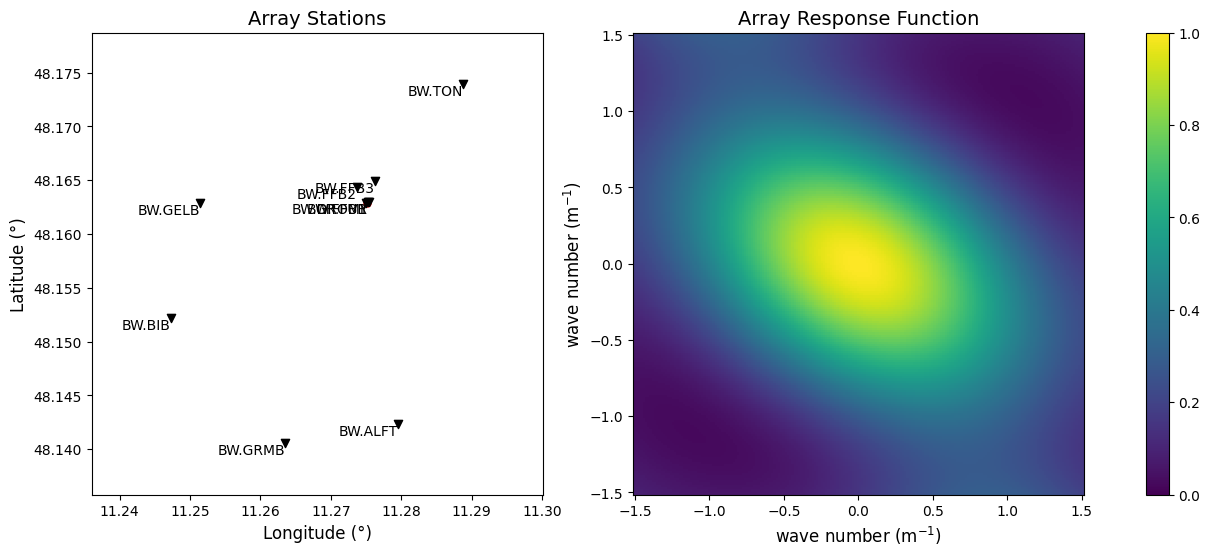

In [214]:
# __plot_array_geometry_and_response0(coordinates,
#                                    transff,
#                                    config['k_max'],
#                                    config['k_step'],
#                                    array_stations.codes,
#                                    unit="deg",
#                                   )

In [264]:
# get maximal distance
# dist_max = max(distances.values())
dist_max = max(cross_distances.reshape(cross_distances.size, 1))[0]

lambda_min = 1*dist_max # in km

config['k_max'] = 3*np.pi/lambda_min
config['k_step'] = config['k_max'] / 100.

coordinates = np.column_stack([array_stations.lon, array_stations.lat, array_stations.elev])

# compute transfer function as a function of wavenumber difference
transff = array_transff_wavenumber(coordinates,
                                   config['k_max'],
                                   config['k_step'],
                                   coordsys='lonlat'
                                   )

In [265]:
array_stations

,codes,lon,lat,elev,x_m,y_m,z_m,utm_n,utm_e,utm_zone,utm_letter
0,BW.ALFT,11.279500,48.142334,0.593,397.55,-2276.36,21.0,5.334633e+06,669567.346291,32.0,U
1,BW.BIB,11.247300,48.152200,0.599,-2029.66,-1250.37,27.0,5.335659e+06,667140.137071,32.0,U
2,BW.DROMY,11.275476,48.162941,0.571,30.44,5.02,-1.0,5.336915e+06,669200.235012,32.0,U
3,BW.FFB1,11.275065,48.162904,0.572,0.00,0.00,0.0,5.336910e+06,669169.797278,32.0,U
4,BW.FFB2,11.273684,48.164357,0.577,-107.46,158.45,5.0,5.337068e+06,669062.337441,32.0,U
5,BW.FFB3,11.276289,48.164883,0.562,84.50,222.64,-10.0,5.337132e+06,669254.292671,32.0,U
6,BW.GELB,11.251400,48.162900,0.628,-1759.57,-52.26,56.0,5.336857e+06,667410.222437,32.0,U
7,BW.GRMB,11.263500,48.140600,0.656,-786.92,-2504.24,84.0,5.334405e+06,668382.879818,32.0,U
8,BW.TON,11.288809,48.173897,0.564,985.54,1252.10,-8.0,5.338162e+06,670155.332442,32.0,U
9,GR.FUR,11.275230,48.162950,0.564,12.12,5.48,-8.0,5.336915e+06,669181.914345,32.0,U


In [266]:
def __plot_array_geometry_and_response(array, transff, klim, kstep, names=None, unit=None, lblxy=[]):

    import numpy as np

    # calulcate geometrical center of array
    array_center = [np.median(array[:, 0]), np.median(array[:, 1])]

    # find geometrical limits of array
    lon_min, lon_max = np.min(array[:, 0]), np.max(array[:, 0])
    lat_min, lat_max = np.min(array[:, 1]), np.max(array[:, 1])

    # define bounds
    kxmin, kxmax, kymin, kymax = -klim, klim, -klim, klim

    # _________________________________________________________

    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    fs = 12

    if unit == "km":
        xdata = (array[:, 0]-array_center[0])*111.
        ydata = (array[:, 1]-array_center[1])*111. * np.cos(array[:, 1]/180.*np.pi)
        x0, y0 = array_center[0]*111., array_center[1]*111. * np.cos(array[1]/180.*np.pi)

    elif unit == "deg":
        xdata = array[:, 0]
        ydata = array[:, 1]
        x0, y0 = array_center[0], array_center[1]

    # plot digital elevation model
    # axes[0].contourf(dem['longitude'],
    #                  dem['latitude'],
    #                  dem['data'],
    #                  cmap="gray",
    #                  levels=list(range(400, 650, 2)),
    #                  )

    cm = axes[0].pcolormesh(dem['longitude'],
                            dem['latitude'],
                            dem['data'],
                            cmap="gray",
                            shading='gouraud',
                            )

    cax = axes[0].inset_axes([0.1, 0.92, 0.2, 0.05])
    cb = plt.colorbar(cm, ax=axes[0], cax=cax, orientation="horizontal")
    cb.set_label("Elevation (m)", fontsize=fs, color="w")
    cb.ax.set_xticklabels(cb.ax.xaxis.get_ticklabels(), color="w")
    cb.ax.xaxis.set_tick_params(color="w")
    cb.outline.set_edgecolor("w")

    # ________________________________________________
    axes[0].scatter(xdata, ydata, s=35, color='black', marker='v', zorder=3)
    axes[0].scatter(x0, y0, color='red', marker='o', s=25, zorder=2)

    if unit == "km" or unit is None:
        axes[0].set_xlabel('X (km)', fontsize=fs)
        axes[0].set_ylabel('Y (km)', fontsize=fs)

        axes[0].set_ylim([-max(abs(ydata))*0.99, max(abs(ydata))*1.01])
        axes[0].set_xlim([-max(abs(xdata))*0.99, max(abs(xdata))*1.01])

    elif unit == "deg":
        axes[0].set_xlabel('Longitude (°)', fontsize=fs)
        axes[0].set_ylabel('Latitude (°)', fontsize=fs)

        axes[0].set_ylim([min(abs(ydata))*0.9999, max(abs(ydata))*1.0001])
        axes[0].set_xlim([min(abs(xdata))*0.999, max(abs(xdata))*1.0009])

    axes[0].set_title('ROMY Array Stations', fontsize=fs+2)

    if len(lblxy) > 0:
        for _i, (x, y, s) in enumerate(zip(xdata, ydata, list(names))):
            dx, dy = lblxy[_i]
            axes[0].text(x+dx, y+dy, s, ha="left", va="top")
    else:
        for x, y, s in zip(xdata, ydata, list(names)):
            axes[0].text(x+.001, y+.0, s, ha="left", va="top")

    # ________________________________________________
    ax2 = axes[1].pcolor(np.arange(kxmin, kxmax + kstep * 1.1, kstep) - kstep / 2.,
                         np.arange(kymin, kymax + kstep * 1.1, kstep) - kstep / 2.,
                         transff.T, cmap=obspy_sequential,
                        )

    cb = plt.colorbar(ax2, ax=axes[:])
    ax2.set_clim(0., 1.)
    cb.set_label("normalized Beam Power", fontsize=fs, color="k", labelpad=-60)

    axes[1].set_xlim(kxmin, kxmax)
    axes[1].set_ylim(kymin, kymax)
    axes[1].set_xlabel('wave number (m$^{-1}$)', fontsize=fs)
    axes[1].set_ylabel('wave number (m$^{-1}$)', fontsize=fs)
    axes[1].set_title('Array Response Function', fontsize=fs+2)

    for _k, ll in enumerate(['(a)','(b)']):
        axes[_k].text(0.006, 0.99, ll, ha="left", va="top", transform=axes[_k].transAxes, fontsize=fs+1, color="w")

    plt.show();
    return fig

/tmp/ipykernel_855035/3355090974.py:49: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cb.ax.set_xticklabels(cb.ax.xaxis.get_ticklabels(), color="w")


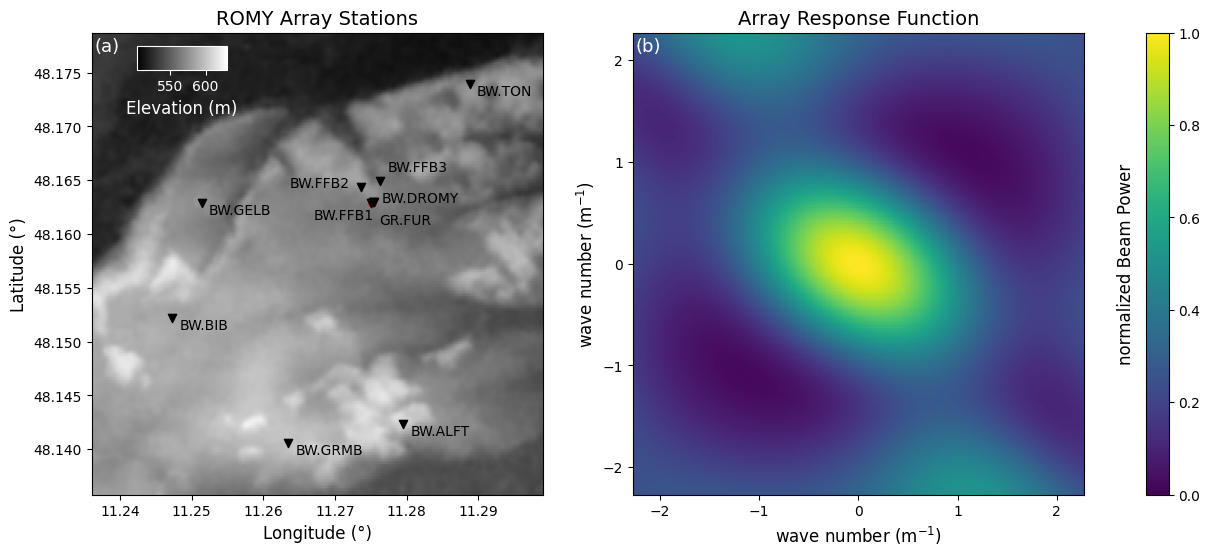

In [267]:
lblxy = [[0.001, 0], [0.001, 0], [0.001, 0.001], [-0.008, -0.0005],
         [-0.01, 0.001], [0.001, 0.002], [0.001, 0], [0.001, 0],
         [0.001, 0.0], [0.001, -0.001]]

fig = __plot_array_geometry_and_response(coordinates,
                                         transff,
                                         config['k_max'],
                                         config['k_step'],
                                         array_stations.codes,
                                         unit="deg",
                                         lblxy=lblxy
                                        )

fig.savefig(config['path_to_figs']+"RomyArray_map_response.png", format="png", dpi=150, bbox_inches='tight')